<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/009_Custom_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## Episode 9: Custom Loss

#### Marco Sanguineti, 2021
---
Welcome to 3 minutes Machine Learning!

Reference: https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

In [24]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [25]:
print(tf.__version__)

2.5.0


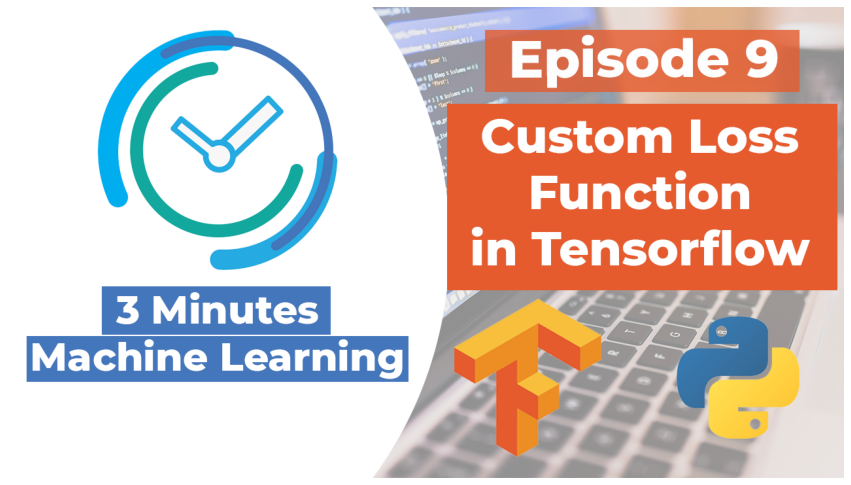

In [26]:
import os
def loadThumb(path):
  # Let's import this video thumbnail!
  if os.path.exists(path):
    myThumb = plt.imread(path)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.axis('off')
    ax.imshow(myThumb)
    plt.show()

loadThumb('/tmp/yt_thumb_009.png')


#### Video Topics
> 1. Load the dataset from UCI.edu
> 2. Create a model with the keras API with a custom layer and custon loss
> 3. Train the model and check the results
> 4. See you on next video! 

# Load the dataset
___

In [27]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"
cols = ['Frequency',
        'Angle of Attack',
        'Chord length',
        'Free-stream velocity',
        'Suction side displacement thickness',
        'Sound Pressure']
dataset = pd.read_table(URL, names=cols, dtype='float32')
dataset

,Frequency,Angle of Attack,Chord length,Free-stream velocity,Suction side displacement thickness,Sound Pressure
0,800.0,0.0,0.3048,71.300003,0.002663,126.200996
1,1000.0,0.0,0.3048,71.300003,0.002663,125.200996
2,1250.0,0.0,0.3048,71.300003,0.002663,125.950996
3,1600.0,0.0,0.3048,71.300003,0.002663,127.591003
4,2000.0,0.0,0.3048,71.300003,0.002663,127.460999
...,...,...,...,...,...,...
1498,2500.0,15.6,0.1016,39.599998,0.052849,110.264000
1499,3150.0,15.6,0.1016,39.599998,0.052849,109.253998
1500,4000.0,15.6,0.1016,39.599998,0.052849,106.603996
1501,5000.0,15.6,0.1016,39.599998,0.052849,106.223999


In [28]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency,1503.0,2886.380615,3152.577637,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Angle of Attack,1503.0,6.782283,5.918133,0.000000,2.000000,5.400000,9.900000,22.200001
Chord length,1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Free-stream velocity,1503.0,50.861012,15.572801,31.700001,39.599998,39.599998,71.300003,71.300003
Suction side displacement thickness,1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
Sound Pressure,1503.0,124.835930,6.898657,103.379997,120.191002,125.721001,129.995499,140.987000


In [6]:
# sns.pairplot(dataset)
# plt.show()

# Create the model
___

In [29]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer

In [30]:
# Let's create a custom quadratic layer
class myDenseLayer(Layer):
  def __init__(self, units=32, activation=None):
    super(myDenseLayer, self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)
  
  def build(self, input_shape):
    a_init = tf.random_normal_initializer()
    self.a = tf.Variable(name='a',
                         initial_value=a_init(shape=(input_shape[-1], self.units)), dtype='float32',
                         trainable=True)
    self.b = tf.Variable(name='b',
                         initial_value=a_init(shape=(input_shape[-1], self.units)), dtype='float32',
                         trainable=True)
    c_init = tf.zeros_initializer()
    self.c = tf.Variable(name='c',
                         initial_value=c_init(shape=(self.units)), dtype='float32',
                         trainable=True)
   
  def call(self, inputs):
    return self.activation(tf.matmul(tf.math.square(inputs), self.a)+tf.matmul(inputs, self.b) + self.c)



In [31]:
myLayer = myDenseLayer(units=64, activation='relu')
myLayer_2 = myDenseLayer(units=64, activation='relu')

In [32]:
#My Custom Regressor Accuracy
import keras.backend as K
import sklearn

class CustomAccuracy(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / tf.reduce_mean(tf.square(y_true)) - 1


In [35]:
import numpy as np
loss = CustomAccuracy()
a = tf.random.uniform(shape=(32, 5))
b = tf.random.uniform(shape=(32, 5))
loss(a, b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.13668084>

In [39]:
input_data = Input(shape=(5), name='Input')
customDense = myLayer(input_data)
customDense_2 = myLayer_2(customDense)
output = Dense(1, name='output')(customDense_2)

model = Model(input_data, output)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CustomAccuracy(), metrics=['mae', 'mse'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
my_dense_layer_1 (myDenseLay (None, 64)                704       
_________________________________________________________________
my_dense_layer_2 (myDenseLay (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


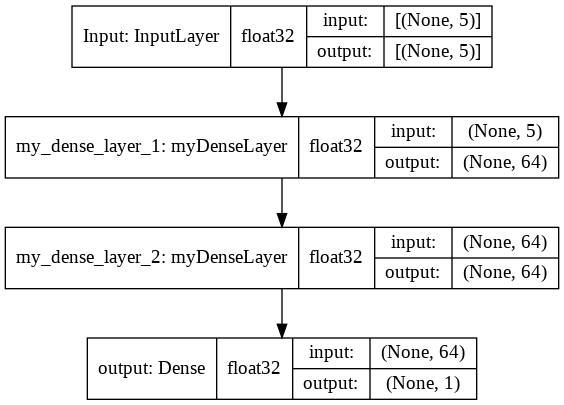

In [40]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [41]:
def separate(df):
  return df[['Sound Pressure']].to_numpy(), df.drop(df[['Sound Pressure']], axis=1).to_numpy()

In [42]:
min_max_scaler = preprocessing.MinMaxScaler()
df_normed = pd.DataFrame(min_max_scaler.fit_transform(dataset))
df_normed.columns = list(dataset.columns)
train_set, test_set = train_test_split(df_normed)
train_labels, train_features = separate(train_set)
test_labels, test_features = separate(test_set)

# Train and check the results
___

In [43]:
myLayer.variables

[<tf.Variable 'my_dense_layer_1/a:0' shape=(5, 64) dtype=float32, numpy=
 array([[ 0.04016633, -0.01031138, -0.11597823,  0.081949  , -0.00588036,
          0.01402716, -0.02986975, -0.05585732,  0.02065415,  0.05828486,
          0.01543024, -0.05143028,  0.00558738, -0.05881307, -0.13305357,
          0.00721211,  0.02641235, -0.06112371, -0.01017828,  0.03942886,
         -0.00610987, -0.00811157,  0.02421825, -0.00871147,  0.07758125,
          0.01299442, -0.07126845,  0.04016223, -0.00236092,  0.03972855,
          0.04162741, -0.01583446, -0.05104306, -0.0398333 , -0.02142453,
         -0.00714978,  0.03756013, -0.03549299,  0.03601113, -0.0096307 ,
         -0.0742312 , -0.03383787, -0.05068895, -0.0965881 , -0.04940413,
         -0.0894789 ,  0.00831799,  0.00661566,  0.0311284 ,  0.00470676,
          0.01164699,  0.05923758,  0.07583516,  0.02357952,  0.0377329 ,
         -0.03628787,  0.00319501,  0.0117116 , -0.04418086,  0.03312588,
         -0.0216225 , -0.08001846, -0.0

In [44]:
history = model.fit(
    train_features,
    train_labels,
    batch_size = 128,
    epochs=500,
    validation_data=(test_features,
                     test_labels)
)
print(f'My final score on testo set {- model.evaluate(test_features, test_labels)[0]}')

Epoch 1/500
9/9 [==============================] - 1s 22ms/step - loss: 0.5816 - mae: 0.5352 - mse: 0.3221 - val_loss: 0.3746 - val_mae: 0.4641 - val_mse: 0.2515
Epoch 2/500
9/9 [==============================] - 0s 5ms/step - loss: 0.1934 - mae: 0.3829 - mse: 0.1835 - val_loss: -0.1185 - val_mae: 0.2726 - val_mse: 0.1033
Epoch 3/500
9/9 [==============================] - 0s 5ms/step - loss: -0.1937 - mae: 0.2402 - mse: 0.0829 - val_loss: -0.2295 - val_mae: 0.2204 - val_mse: 0.0787
Epoch 4/500
9/9 [==============================] - 0s 5ms/step - loss: -0.2526 - mae: 0.2170 - mse: 0.0709 - val_loss: -0.3446 - val_mae: 0.1928 - val_mse: 0.0570
Epoch 5/500
9/9 [==============================] - 0s 4ms/step - loss: -0.3313 - mae: 0.1989 - mse: 0.0567 - val_loss: -0.3924 - val_mae: 0.1810 - val_mse: 0.0490
Epoch 6/500
9/9 [==============================] - 0s 5ms/step - loss: -0.4076 - mae: 0.1755 - mse: 0.0449 - val_loss: -0.4510 - val_mae: 0.1599 - val_mse: 0.0400
Epoch 7/500
9/9 [=======

In [45]:
myLayer.variables

[<tf.Variable 'my_dense_layer_1/a:0' shape=(5, 64) dtype=float32, numpy=
 array([[-1.71889123e-02, -7.47029841e-01, -1.25030696e-01,
         -6.06650785e-02, -1.19791806e-01, -1.81338429e-01,
         -8.41911435e-02, -1.39669016e-01,  1.08233688e-03,
         -5.84812202e-02, -1.64579283e-02, -3.41677576e-01,
         -1.25120685e-03, -1.88889325e-01, -1.97985813e-01,
          4.36299145e-02, -1.16349347e-01,  9.26098321e-03,
         -2.78926753e-02,  1.06163532e-01, -1.28895156e-02,
         -2.28219882e-01,  1.36134271e-02, -5.21474741e-02,
          1.34202853e-01, -9.17449668e-02, -7.65851811e-02,
          4.29822169e-02, -2.54580170e-01, -1.29580975e-01,
         -6.46240711e-02, -3.25376913e-02, -1.79525897e-01,
         -1.99425578e-01, -3.95421647e-02, -2.34552667e-01,
         -2.09235568e-02, -4.32431065e-02, -2.82458477e-02,
         -1.41278535e-01, -4.59738761e-01, -7.39153251e-02,
         -2.02970028e-01, -9.65881050e-02, -3.67600918e-02,
         -1.53069675e-01, -

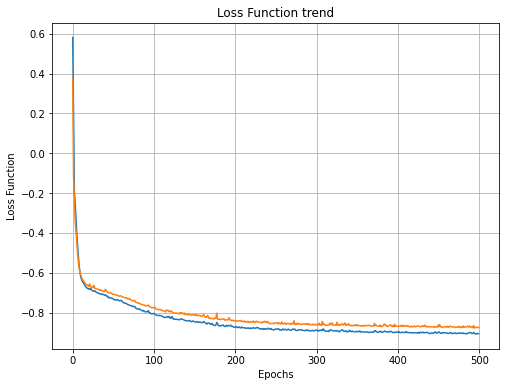

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(loss)
plt.plot(val_loss)
plt.grid('both')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.title('Loss Function trend')
plt.show()


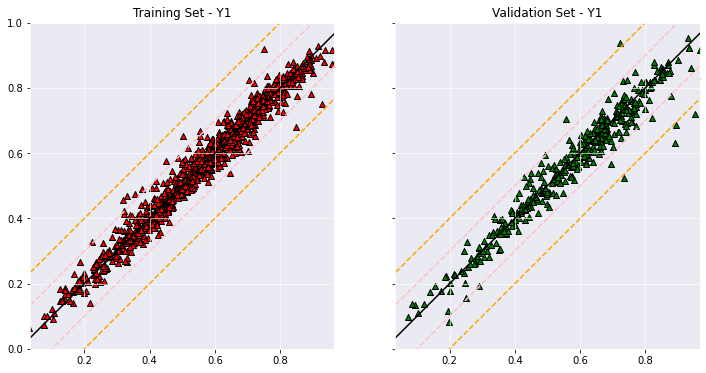

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].axis('equal')
ax[0].scatter(train_labels[:, 0], model.predict(train_features)[:, 0], marker='^',
          color='r', edgecolor='k')
ax[0].plot([0, 1], [0, 1], c='k')
ax[0].plot([0, 1], [0.2, 1.2],'--', c='orange')
ax[0].plot([0, 1], [-0.2, 0.8],'--', c='orange')
ax[0].plot([0, 1], [0.1, 1.1],'--', c='pink')
ax[0].plot([0, 1], [-0.1, 0.9],'--', c='pink')
ax[0].set_title('Training Set - Y1')
ax[0].set_ylim(0, 1)
ax[0].grid(which='both', alpha=0.8, c='white')
ax[0].set_facecolor('#eaeaf2')
ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].spines['left'].set_color('white')

ax[1].axis('equal')
ax[1].scatter(test_labels[:, 0], model.predict(test_features)[:, 0], marker='^',
          color='g', edgecolor='k')
ax[1].plot([0, 1], [0, 1], c='k')
ax[1].plot([0, 1], [0.2, 1.2],'--', c='orange')
ax[1].plot([0, 1], [-0.2, 0.8],'--', c='orange')
ax[1].plot([0, 1], [0.1, 1.1],'--', c='pink')
ax[1].plot([0, 1], [-0.1, 0.9],'--', c='pink')
ax[1].set_title('Validation Set - Y1')
ax[1].set_ylim(0, 1)
ax[1].grid(which='both', alpha=0.8, c='white')
ax[1].set_facecolor('#eaeaf2')
ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')
ax[1].spines['left'].set_color('white')

In [48]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
for i in range(np.shape(train_labels)[1]): 
  metrics= {
      'mae-train': np.mean(np.abs(train_labels[:, i] - model.predict(train_features)[:, i])),
      'mse-train': np.mean(np.square(train_labels[:, i] - model.predict(train_features)[:, i])),
      'r2-train': r2_score(train_labels[:, i], model.predict(train_features)[:, i]),
      'pearson-train': pearsonr(train_labels[:, i], model.predict(train_features)[:, i])[0],
      'mae-test': np.mean(np.abs(test_labels[:, i] - model.predict(test_features)[:, i])),
      'mse-test': np.mean(np.square(test_labels[:, i] - model.predict(test_features)[:, i])),
      'r2-test': r2_score(test_labels[:, i] ,model.predict(test_features)[:, i]),
      'pearson-test': pearsonr(test_labels[:, i], model.predict(test_features)[:, i])[0]
  }

  blue = lambda x: '\033[94m' + x + '\033[0m'
  yellow = lambda x: '\033[93m' + x + '\033[0m'

  for key in metrics:
      if 'train' in key:
          print(f'Y{i} - {blue(key)} - {str(metrics[key])[:7]}')
      else:
          print(f'Y{i} - {yellow(key)} - {str(metrics[key])[:7]}')

Y0 - mae-train - 0.02317
Y0 - mse-train - 0.00105
Y0 - r2-train - 0.96827
Y0 - pearson-train - 0.98411
Y0 - mae-test - 0.03044
Y0 - mse-test - 0.00207
Y0 - r2-test - 0.94029
Y0 - pearson-test - 0.96992


# Greetings
---

In [49]:
!pip install art
from art import tprint, aprint
tprint('See you on next videos!')
def subscribe():
  """
  Attractive subscription form
  """
  aprint("giveme", number=5)
  print(f'\n\tLike and subscribe to support this work!\n')
  aprint("giveme", number=5)
subscribe()

 ____                                                                        _            _      _                    _ 
/ ___|   ___   ___   _   _   ___   _   _    ___   _ __    _ __    ___ __  __| |_  __   __(_)  __| |  ___   ___   ___ | |
\___ \  / _ \ / _ \ | | | | / _ \ | | | |  / _ \ | '_ \  | '_ \  / _ \\ \/ /| __| \ \ / /| | / _` | / _ \ / _ \ / __|| |
 ___) ||  __/|  __/ | |_| || (_) || |_| | | (_) || | | | | | | ||  __/ >  < | |_   \ V / | || (_| ||  __/| (_) |\__ \|_|
|____/  \___| \___|  \__, | \___/  \__,_|  \___/ |_| |_| |_| |_| \___|/_/\_\ \__|   \_/  |_| \__,_| \___| \___/ |___/(_)
                     |___/                                                                                              

༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ 

	Like and subscribe to support this work!

༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ ༼ つ ◕_◕ ༽つ 
